In [1]:
import torch
      # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker


import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

from FVM_1D import fvm_1D
from coPINN_1D import coPINN_1D_Solver
from Residuals import res_compare

from Plot_1D_Solutions import save_imshow_sidebyside

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
#Code partially from ChatGPT
# dT/dt = alpha*d^2T/dx^2 + beta*C
# dC/dt = D*d^2T/dx^2 + gamma*C
#T(0,t)=T(L,t)=0,C(0,t)=C(L,t)=0 Boundaries #Sometimes I change
#Initial T(x,0)=f(x),C(x,0)=g(x)

torch.pi = torch.acos(torch.zeros(1)).item() * 2

def initial_TC(x):
    # T_init = np.array(x<0.5,dtype = 'int')
    # C_init = np.array(x>0.5,dtype = 'int')

    T_init = 0.0*x
    # C_init = 1.0 + 0.0*x
    C_init = np.sin(2*np.pi*x)

    # T_init = np.sin(np.)

    return T_init,C_init

def boundary_TC(x):
    T1 = 0
    T2 = 0
    C1 = 0
    C2 = 0

    return T1,T2,C1,C2

def forcing_func(x):

    return np.sin(2*np.pi*x)

def forcing_func_torch(x):

    return torch.sin(2*torch.pi*x)

In [3]:
t_end = 1


L = 1.0            # Length of the rod
          # Number of cells
      
alpha = 0.01       # Thermal diffusivity
D = 0.01           # Diffusion coefficient
beta = 1.0         # Coupling coefficient for temperature
gamma = 1.0        # Coupling coefficient for concentration

pde_related_funcs = {'initial_condition':initial_TC,"boundary_conditions":boundary_TC,
                     "forcing_function":forcing_func,"forcing_function_torch":forcing_func_torch}

problem_constants = {"L":L,"Max_time":t_end,"alpha":alpha,"beta":beta,"gamma":gamma,"D":D}

In [4]:
# Parameters
N_x = 200 
t_steps = 1001

T_FVM, C_FVM = fvm_1D(pde_related_funcs,problem_constants,N_x,t_steps)


T_FVM_norm = np.linalg.norm(T_FVM,2)
C_FVM_norm = np.linalg.norm(C_FVM,2)

fvm_results = {'T_FVM': T_FVM,'C_FVM':C_FVM,"T_FVM_norm":T_FVM_norm,"C_FVM_norm":C_FVM_norm}

Elapsed Time 0.497788


In [5]:
optimizer_algo = "LBFGS" #or Adam
max_iter = 100 #200

N_T = 2000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 

layers1 = np.array([2,50,50,50,50,1]) #9 hidden layers
layers2 = np.array([2,50,50,50,50,1]) #9 hidden layers

coPINN_constants = {"N_T":N_T,"N_f":N_f,"max_iter" :max_iter,"layers1":layers1,"layers2":layers2,
                    "optimizer_algo":optimizer_algo,"device":device,"fvm_results":fvm_results}

In [6]:
coPINN_solver = coPINN_1D_Solver(coPINN_constants,pde_related_funcs,problem_constants,N_x,t_steps)
coPINN_trained = coPINN_solver.train_model(1)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 0.19894086 RD T: 0.6927908815609718 RD C: 0.9333156812281755
1 Train Loss 0.09135138 RD T: 0.24419883943133236 RD C: 0.4452282624359654
2 Train Loss 0.012969345 RD T: 0.10031974664823114 RD C: 0.10706810610637442
3 Train Loss 0.00244265 RD T: 0.05800103437407493 RD C: 0.040914619798862545
4 Train Loss 0.0009550142 RD T: 0.050657093855403984 RD C: 0.024400106159027605
5 Train Loss 0.00048014757 RD T: 0.05094307132974183 RD C: 0.024770729174389067
6 Train Loss 0.00031187152 RD T: 0.0

In [7]:
T_PINN,C_PINN = coPINN_trained.test()
s = T_FVM.shape
T_PINN = T_PINN.reshape(s[0],s[1])
C_PINN = C_PINN.reshape(s[0],s[1])

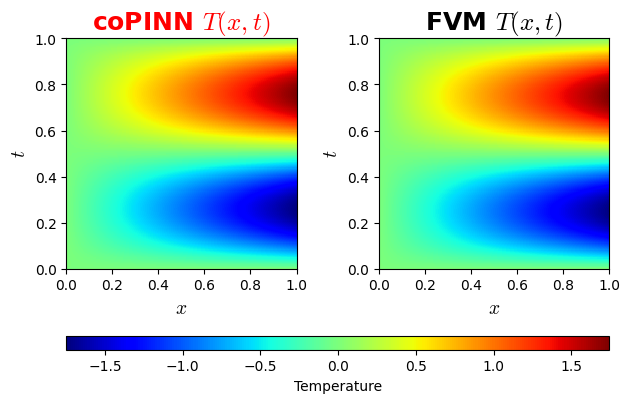

In [8]:
fixed_params = {'xlabel': '$x$','ylabel': '$t$','extent': [0,L,0,t_end],
                'proposed_indicator': 0,'aspect':1}

data = [T_PINN,T_FVM]
title = ['coPINN $T(x,t)$','FVM $T(x,t)$']
colorbar_label = 'Temperature'
save_name = "Temp_1D_Values"
vmax = np.max(T_PINN)
vmin = np.min(T_PINN)


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)


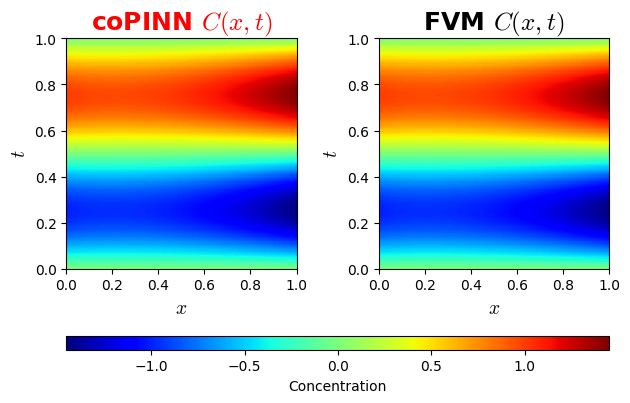

In [9]:
data = [C_PINN,C_FVM]
title = ['coPINN $C(x,t)$','FVM $C(x,t)$']
colorbar_label = 'Concentration'
save_name = "Conc_1D_Values"
vmax = np.max(C_PINN)
vmin = np.min(C_PINN)


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)


In [10]:
opt = 'grid'

interp_method = 'spline'

f1_PINN_spline,f1_fvm_spline,f2_PINN_spline,f2_fvm_spline = res_compare(opt,interp_method,pde_related_funcs,problem_constants,
                                            N_x,t_steps,T_FVM,C_FVM,coPINN_trained,device,
                                            NN_interp_constants=None)

(200, 1001)
(200, 1001)
(200, 1001)
PINN_f1: 0.0020
FVM_f1: 0.0069
PINN_f2: 0.0016
FVM_f2: 0.1048


In [11]:
opt = 'grid'

interp_method = 'NN'

interp_layers = [2,50,50,50,50,1]
interp_device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
interp_max_iter = 5000

NN_constants = {"layers":interp_layers,"device":interp_device,"max_iter":interp_max_iter}



f1_PINN_NN,f1_fvm_NN,f2_PINN_NN,f2_fvm_NN = res_compare(opt,interp_method,pde_related_funcs,problem_constants,
                                            N_x,t_steps,T_FVM,C_FVM,coPINN_trained,device,
                                            NN_interp_constants=NN_constants)

Loss after (interpolation) training: 0.00
Loss after (interpolation) training: 0.00
PINN_f1: 0.0020
FVM_f1: 21.8678
PINN_f2: 0.0016
FVM_f2: 24.7140


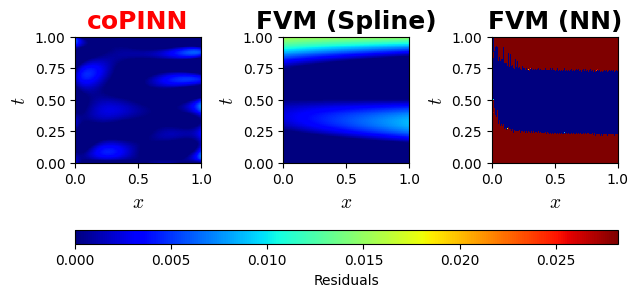

In [12]:
data = [f1_PINN_spline,f1_fvm_spline,f1_fvm_NN]
title = ['coPINN','FVM (Spline)','FVM (NN)']
colorbar_label = 'Residuals'
save_name = "Residuals_HeatEquation"
vmax = np.max(np.abs(f1_fvm_spline))
vmin = 0


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)

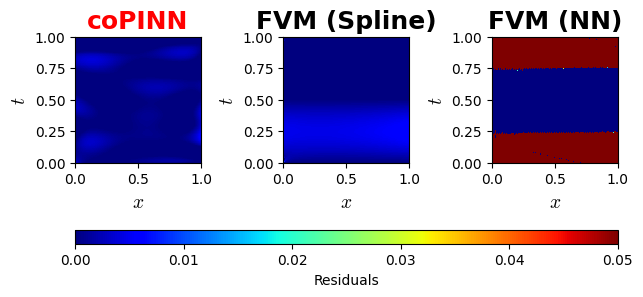

In [13]:
data = [f2_PINN_spline,f2_fvm_spline,f2_fvm_NN]
title = ['coPINN','FVM (Spline)','FVM (NN)']
colorbar_label = 'Residuals'
save_name = "Residuals_DiffusionEquation"
# vmax = np.max(np.abs(f2_fvm))
vmax = 0.05
vmin = 0


plot_data = {"fixed_params": fixed_params,"data":data,'title':title,"vmax":vmax,"vmin":vmin,
             "colorbar_label":colorbar_label,"save_name":save_name}


save_imshow_sidebyside(plot_data)

In [14]:
opt = 'neutral'

interp_method = 'spline'

f1_PINN_spline,f1_fvm_spline,f2_PINN_spline,f2_fvm_spline = res_compare(opt,interp_method,pde_related_funcs,problem_constants,
                                            N_x,t_steps,T_FVM,C_FVM,coPINN_trained,device,
                                            NN_interp_constants=None)

(200, 1001)
(200, 1001)
(200, 1001)
PINN_f1: 0.0016
FVM_f1: 0.0043
PINN_f2: 0.0012
FVM_f2: 0.0038


In [15]:
opt = 'neutral'

interp_method = 'NN'

interp_layers = [2,50,50,50,50,1]
interp_device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
interp_max_iter = 5000

NN_constants = {"layers":interp_layers,"device":interp_device,"max_iter":interp_max_iter}



f1_PINN_NN,f1_fvm_NN,f2_PINN_NN,f2_fvm_NN = res_compare(opt,interp_method,pde_related_funcs,problem_constants,
                                            N_x,t_steps,T_FVM,C_FVM,coPINN_trained,device,
                                            NN_interp_constants=NN_constants)

Loss after (interpolation) training: 0.01
Loss after (interpolation) training: 0.00
PINN_f1: 0.0017
FVM_f1: 21.2031
PINN_f2: 0.0013
FVM_f2: 24.0496
